In [1]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

#import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle
import urllib.parse

from sklearn.externals import joblib 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
MONGODB_HOST = pd.read_csv('./database/auth')['host'][0]
username = urllib.parse.quote_plus(pd.read_csv('./database/auth')['username'][0])
password = urllib.parse.quote_plus(pd.read_csv('./database/auth')['password'][0])
conn = MongoClient('mongodb://%s:%s@%s' % (username, password, MONGODB_HOST))
conn.database_names()

['1071_Common_English',
 'AU',
 'CYCU_1031SP',
 'CYCU_1032OS',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU',
 'KU_dataset_1',
 'KU_dataset_2',
 'KyoU',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_CL',
 'NCU_ETS',
 'NCU_FC',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'Warn',
 'admin',
 'config',
 'local']

In [4]:
datasets = 'NCUx107_Pre_college_calculas'
db = conn[datasets]
db.collection_names()

['pre_25f_data',
 'students_grades',
 'pre_test.csv',
 'ma_w8',
 'students_grades2',
 'after_test.csv']

In [5]:
def flatten(row):
    for grade in row['grades']:
        row[grade['name']] = grade['score']
    return row

In [6]:
collection = db['students_grades']
score_df = pd.DataFrame(list(collection.find()))
score_df.head(5)

,_id,bonusGrade,finalScore,grades,name,rollCallGrade,stageGrade,studentId
0,5bf3a16ad6cace4f10caa0d0,1.5,35,"[{'name': '週考一', 'score': 59}, {'name': '週考二',...",白 阡,9,0,107202505
1,5bf3a16ad6cace4f10caa0d1,10,64,"[{'name': '週考一', 'score': 75}, {'name': '週考二',...",林家宏,11,5,107202506
2,5bf3a16ad6cace4f10caa0d2,10.5,71,"[{'name': '週考一', 'score': 72}, {'name': '週考二',...",江科熹,10,3,107202507
3,5bf3a16ad6cace4f10caa0d3,11.5,82,"[{'name': '週考一', 'score': 86}, {'name': '週考二',...",李思杰,10,4,107202510
4,5bf3a16ad6cace4f10caa0d4,6,78,"[{'name': '週考一', 'score': 51}, {'name': '週考二',...",黃郁芬,11,3,107203503


In [7]:
collection = db['students_grades']
score_df = pd.DataFrame(list(collection.find()))
score_df = score_df.drop(['_id'], axis=1)
score_df = score_df[['studentId', 'finalScore']]
# score_df = score_df.apply(flatten, axis=1)
# score_df = score_df[['studentId', '期末考']]
# score_df = score_df.rename(index=str, columns={"期末考": "finalScore"})
score_df = score_df.rename(index=str, columns={"studentId": "username"})
score_df.head(5)

,username,finalScore
0,107202505,35
1,107202506,64
2,107202507,71
3,107202510,82
4,107203503,78


In [8]:
db = conn[datasets]
collection = db['ma_w8']
feature_df = pd.DataFrame(list(collection.find()))

feature_df = feature_df.drop(['_id'], axis=1)
feature_df = feature_df.drop(['email'], axis=1)
feature_df = feature_df.drop(['label'], axis=1)
feature_df = feature_df.drop(['course_id'], axis=1)
#feature_df = feature_df.drop(['week'], axis=1)
#feature_df = feature_df.drop(['username'], axis=1)
# feature_df = feature_df.drop(['forum_avg_count'], axis=1)
# feature_df = feature_df.drop(['forum_num_days'], axis=1)
# feature_df = feature_df.drop(['forum_sum_count'], axis=1)
# feature_df = feature_df.drop(['num_incomplete'], axis=1)
# feature_df = feature_df.drop(['incomplete_rate'], axis=1)
# feature_df = feature_df.drop(list(feature_df.filter(regex='sum$', axis=1)), axis=1)
# feature_df = feature_df.drop(list(feature_df.filter(regex='^all_type_video', axis=1)), axis=1)
# feature_df = feature_df.drop(list(feature_df.filter(regex='^video_pause_', axis=1)), axis=1)

# select_list = [list(feature_df)[i] for i in [0, 1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 16, 18, 23, 24, 25]]
# feature_df = feature_df[select_list]

eature_df = feature_df.fillna('0')
#feature_df = feature_df[list(feature_df)]

# list(feature_df)

<Figure size 1080x1080 with 0 Axes>

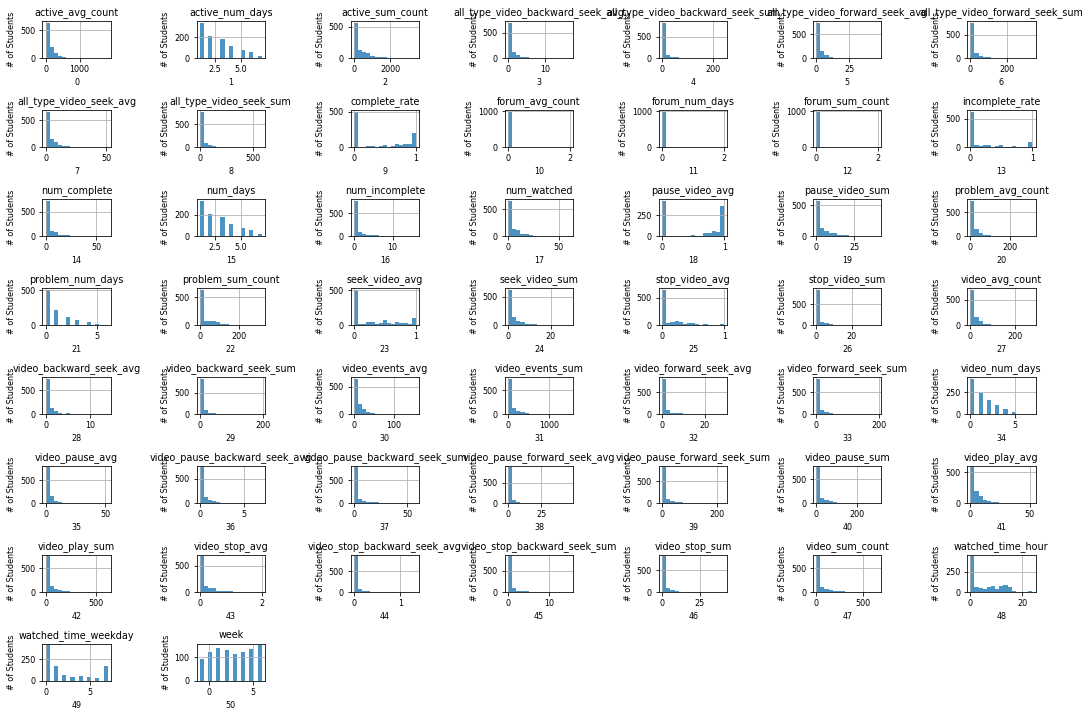

In [9]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15, 15))
ax = feature_df.hist(alpha=0.8, bins=15, figsize=(15, 10))
#for x in ax:
#     x.set_title('x')

i=0
for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel(i)
        i=i+1
plt.tight_layout()

In [10]:
ncu_ets = pd.merge(feature_df, score_df, on='username')
ncu_ets = ncu_ets.drop(['username'], axis=1)
ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['finalScore'] < 60
ncu_ets = ncu_ets.drop(['finalScore'], axis=1)
#ncu_ets.head(5)

len(list(ncu_ets))

51

In [11]:
#x = feature_df.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(X)
#df = pd.DataFrame(x_scaled)

In [12]:
X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

#X = SelectKBest(chi2, k=10).fit_transform(X, y)
#X_new.shape

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5,
                     gamma='scale')


# clf_binary = svm.SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
#   max_iter=-1, probability=True, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                         random_state=5,
                         gamma='scale')


In [13]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    pred_list = []
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        
        # Save Model
        model_name = 'models/' + datasets + '_' + str(title) + '_' + str(i) + '.pkl'
        joblib.dump(clf_binary, model_name)
        
        # Create Predict Matrix
        temp_df = pd.DataFrame({title: y_pred[:, 1].round()},
                               index=test)
        pred_list.append(temp_df)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1

    pred_pd = pd.concat(pred_list)
    
    # Plot
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs, pred_pd

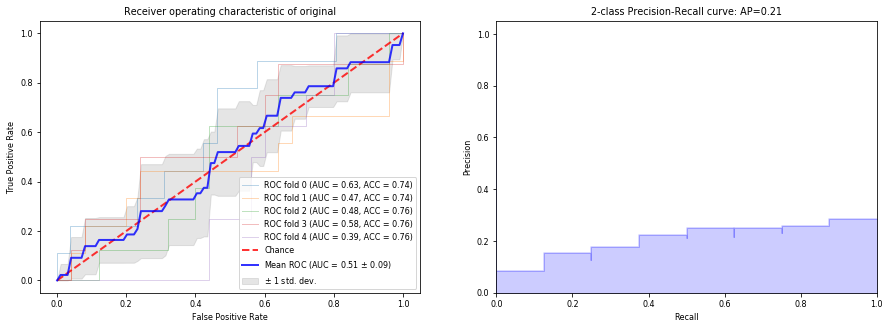

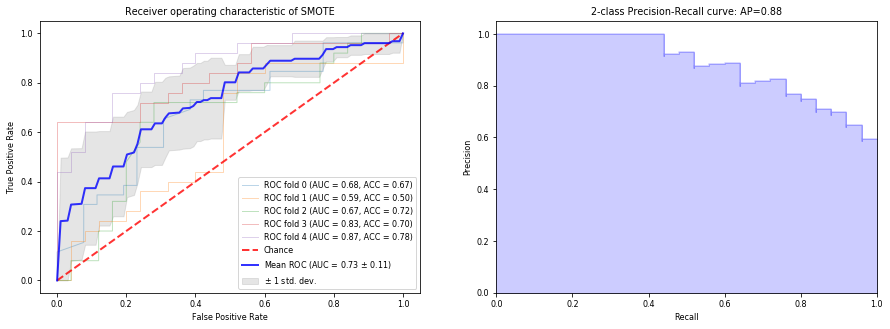

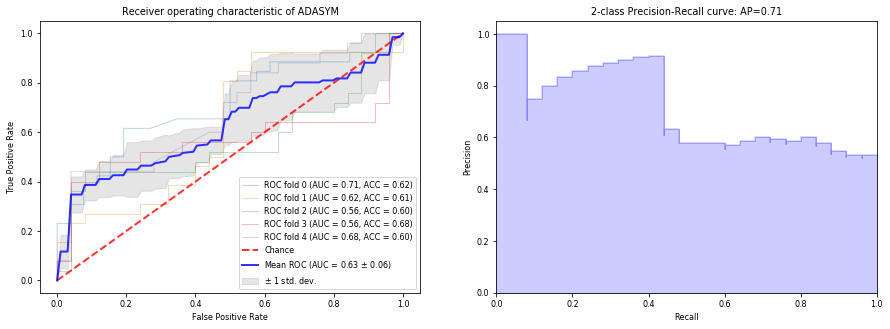

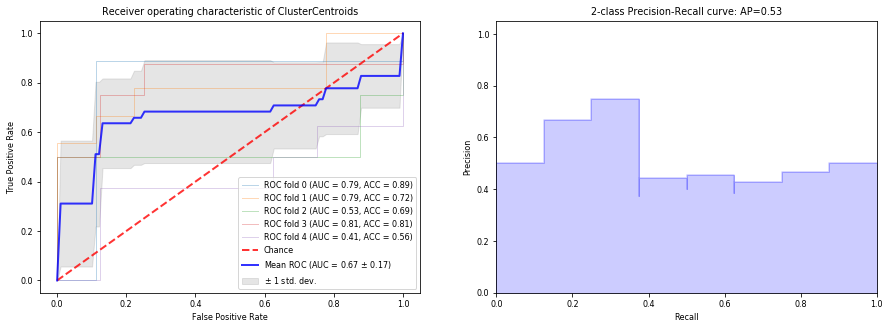

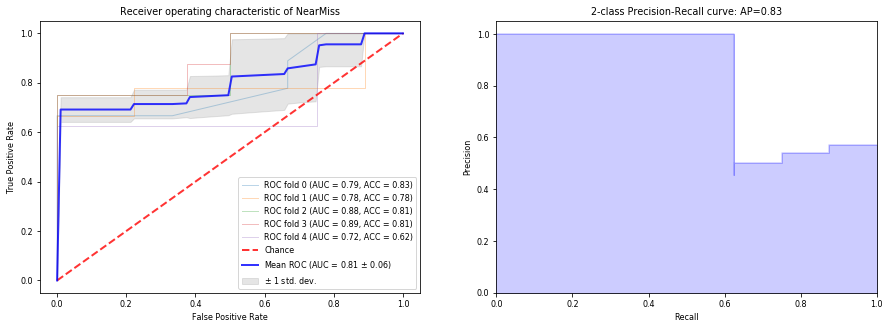

In [14]:
auc_ori, pred_pd_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm, pred_pd_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada, pred_pd_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc, pred_pd_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm, pred_pd_nm = compute_roc(res_X, res_y, title='NearMiss')

In [15]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.01078587397386046
two-sample wilcoxon-test 0.07183604090348011
two-sample wilcoxon-test 0.10503752039332925
two-sample wilcoxon-test 0.006092890177672406


# Engagement

In [16]:
# clf_original = joblib.load('models/NCUx107_Pre_college_calculas_original_1.pkl')
# y_pred = clf_original.predict_proba(X)
# clf_resample = joblib.load('models/NCUx107_Pre_college_calculas_ClusterCentroids_2.pkl')
# y_pred_res = clf_binary.fit(X, y).predict_proba(X)

# #res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
# #y_pred_res = clf_binary.fit(res_X, res_y).predict_proba(X)

In [17]:
# temp_pd = ncu_ets
# #temp_pd = pd.DataFrame(X)
# temp_pd['original'] = y_pred[:, 1].round()
# temp_pd['smote'] = y_pred_res[:, 1].round()
# #temp_pd['class'] = pd.DataFrame(y)
# temp_pd

In [18]:
temp_pd = ncu_ets
temp_pd['original'] = pred_pd_ori
temp_pd['smote'] = pred_pd_sm
temp_pd['adasyn'] = pred_pd_ada
temp_pd['ClusterCentroids'] = pred_pd_cc
temp_pd['NearMiss'] = pred_pd_nm

best_resampler = 'smote'

In [19]:
#risk
T1 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0)])
T2 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0)])
T3 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd[best_resampler] == 0.0)])
T4 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd[best_resampler] == 1.0)])
#non-risk
T5 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0)])
T6 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0)])
T7 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd[best_resampler] == 0.0)])
T8 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd[best_resampler] == 1.0)])

print(' Risk:', T1, T2, 
      '\n Risk(after resample):', T3, T4,
      '\n Non-Risk:', T5, T6, 
      '\n Non-Risk(after resample):',T7, T8)

 Risk: 42 0 
 Risk(after resample): 19 23 
 Non-Risk: 126 0 
 Non-Risk(after resample): 83 43


In [20]:
# origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0)]
# smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd[best_resampler] == 1.0)]
# origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0)]
# smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd[best_resampler] == 0.0)]

origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]
origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

In [21]:
# #plt.figure(figsize=(15, 15))
# ax = origin_pd[list(origin_pd)[0:10]].hist(alpha=0.8, bins=15, figsize=(15, 10))

# for array in ax:
# #     for subplot in array:
#         subplot.set_ylabel('# of Students')
#         subplot.set_xlabel('Count')

# plt.tight_layout()
# image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
# plt.savefig(image_name, dpi=300)

In [22]:
# ax = smote_pd[list(smote_pd)[0:10]].hist(alpha=0.8, bins=15, figsize=(15, 10))

# for array in ax:
#     for subplot in array:
#         subplot.set_ylabel('# of Students')
#         subplot.set_xlabel('Count')

# plt.tight_layout()
# image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
# plt.savefig(image_name, dpi=300)

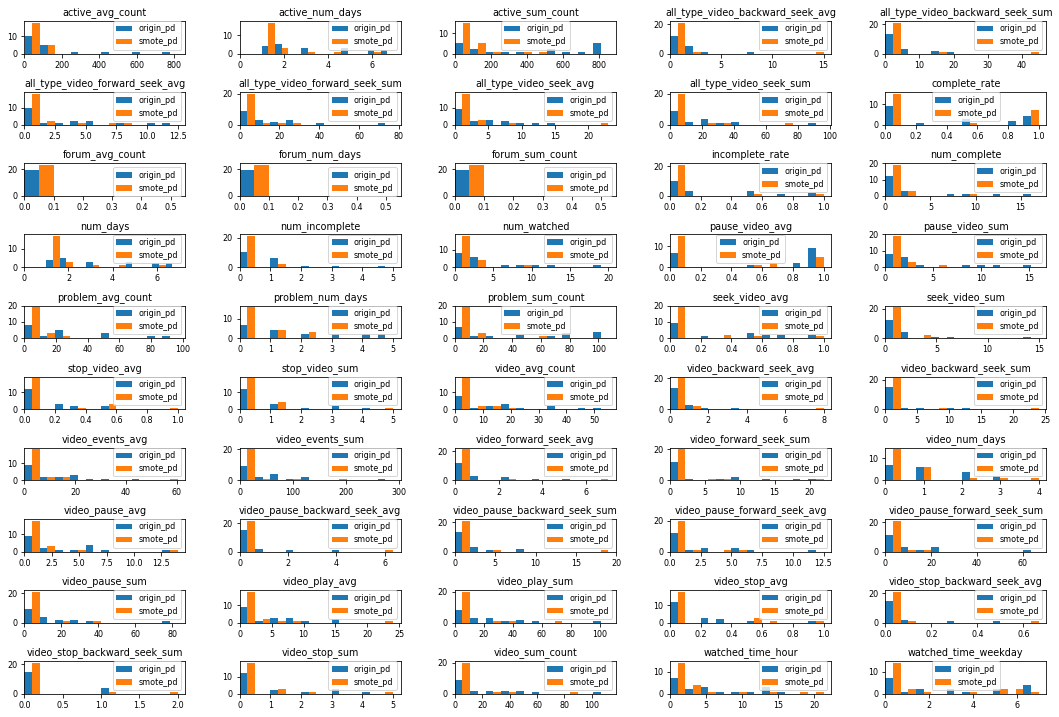

In [23]:
plt.rcParams.update({'font.size': 8})
titles = list(origin_pd)

fig, axes = plt.subplots(10,5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd[list(origin_pd)[idx]].values, 
            smote_pd[list(smote_pd)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'smote_identified' + '.png'
plt.savefig(image_name, dpi=300)

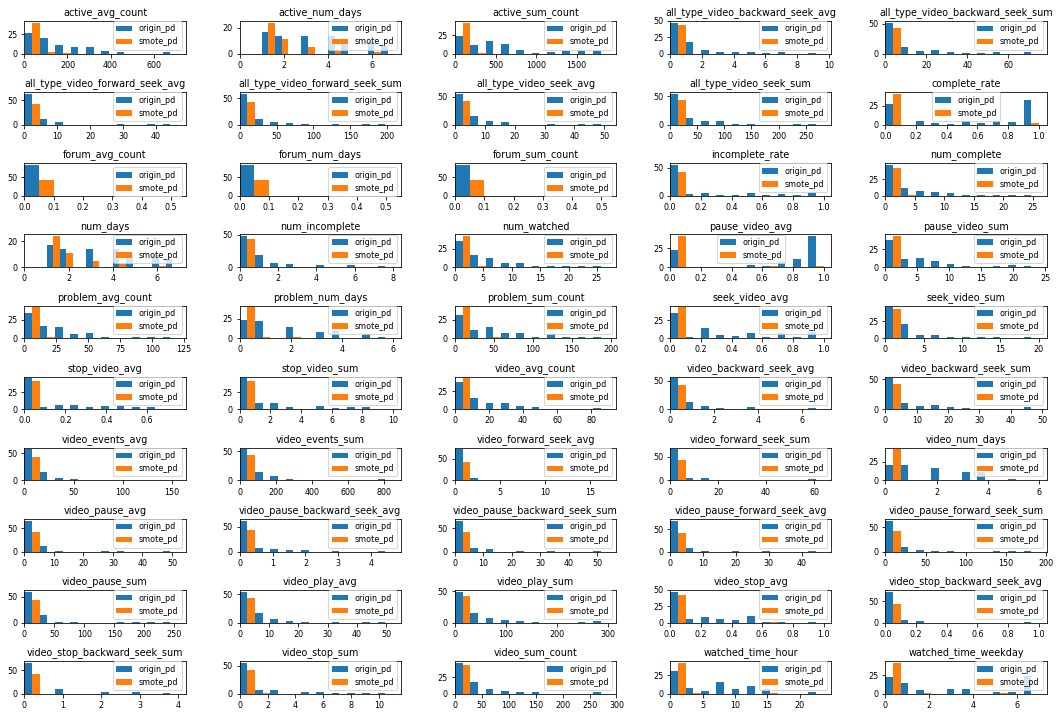

In [24]:
plt.rcParams.update({'font.size': 8})
titles = list(origin_pd)

fig, axes = plt.subplots(10,5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd_t5[list(origin_pd_t5)[idx]].values,
            smote_pd_t6[list(smote_pd_t6)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()

image_name = './images/' + datasets + '_' + 'smote_misidentified' + '.png'
plt.savefig(image_name, dpi=300)

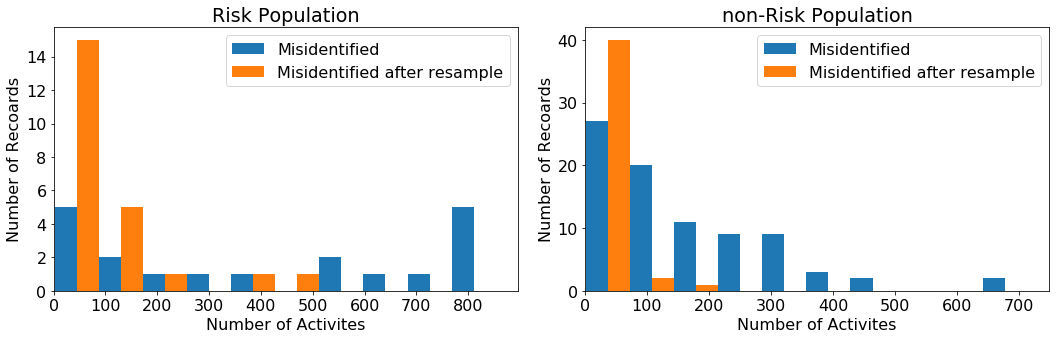

In [31]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins=10

ax[0].hist([origin_pd[list(origin_pd)[2]].values,
            smote_pd[list(smote_pd)[2]].values],
            label=['Misidentified', 'Misidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[0].legend()
ax[0].set_xlabel('Number of Activites')
ax[0].set_ylabel('Number of Recoards')
ax[0].set_title('Risk Population')
ax[0].set_xlim(left=0)

ax[1].hist([origin_pd_t5[list(origin_pd_t5)[0]].values,
            smote_pd_t6[list(smote_pd_t6)[0]].values],
            label=['Misidentified', 'Misidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[1].legend()
ax[1].set_xlabel('Number of Activites')
ax[1].set_ylabel('Number of Recoards')
ax[1].set_title('non-Risk Population')
ax[1].set_xlim(left=0)

plt.tight_layout()
image_name = './images/' + datasets + '_' + list(origin_pd)[2] + '.png'
plt.savefig(image_name, dpi=300)

# Confusion Metrix

In [26]:
plt.rcParams.update({'font.size': 16})

vegetables = ["Identified",
              "Mis-identified"]
farmers = ["Risk", "Non-Risk"]


./images/NCUx107_Pre_college_calculas_c_matrix.png


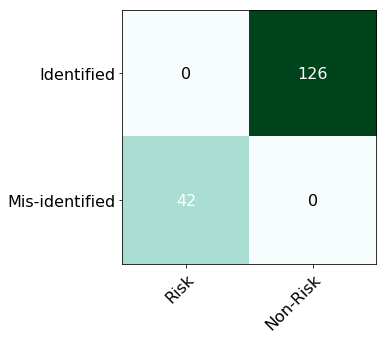

In [34]:
harvest = np.array([[T2, T5],
                    [T1, T6]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 30: 
            color='white'
        else:
            color='black'    
        #text = ax.text(j, i, "{0:.0%}".format(harvest[i, j] / harvest.sum()),
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color=color)

fig.tight_layout()

image_name = './images/' + datasets + '_' + 'c_matrix' + '.png'
print(image_name)
plt.savefig(image_name, dpi=300)

plt.show()

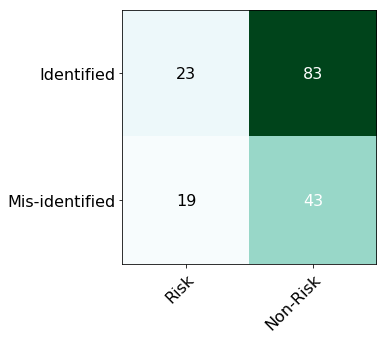

In [32]:
harvest = np.array([[T4, T7],
                    [T3, T8]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 30: 
            color='white'
        else:
            color='black'    
        #text = ax.text(j, i, "{0:.0%}".format(harvest[i, j] / harvest.sum()),
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color=color)

fig.tight_layout()

image_name = './images/' + datasets + '_' + 'c_matrix_res' + '.png'
plt.savefig(image_name, dpi=300)

plt.show()

In [29]:
# from sklearn.model_selection import GridSearchCV

# #X = ncu_ets.drop(['class'], axis=1)
# #X = X.values
# #y = ncu_ets['class']

# C_range = 10. ** np.arange(-3, 8)
# gamma_range = 10. ** np.arange(-5, 4)
# #kernel_range = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# kernel_range = ['linear']
# #probability_range = [True]

# param_grid = dict(gamma=gamma_range, 
#                   C=C_range, 
#                   kernel=kernel_range)

# grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
# grid.fit(X, y)
# # y_pred = grid.fit(X, y).predict_proba(X)
# # acc = accuracy_score(y, y_pred[:, 1].round())

# # fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])

# # roc_auc = auc(fpr, tpr)

# #y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
# #acc = accuracy_score(y[test], y_pred[:, 1].round())

# print("The best classifier is: ", grid.best_estimator_)
# # print("Accuracy: ", acc)
# # print("AUC: ", roc_auc)

<Figure size 1080x1080 with 0 Axes>

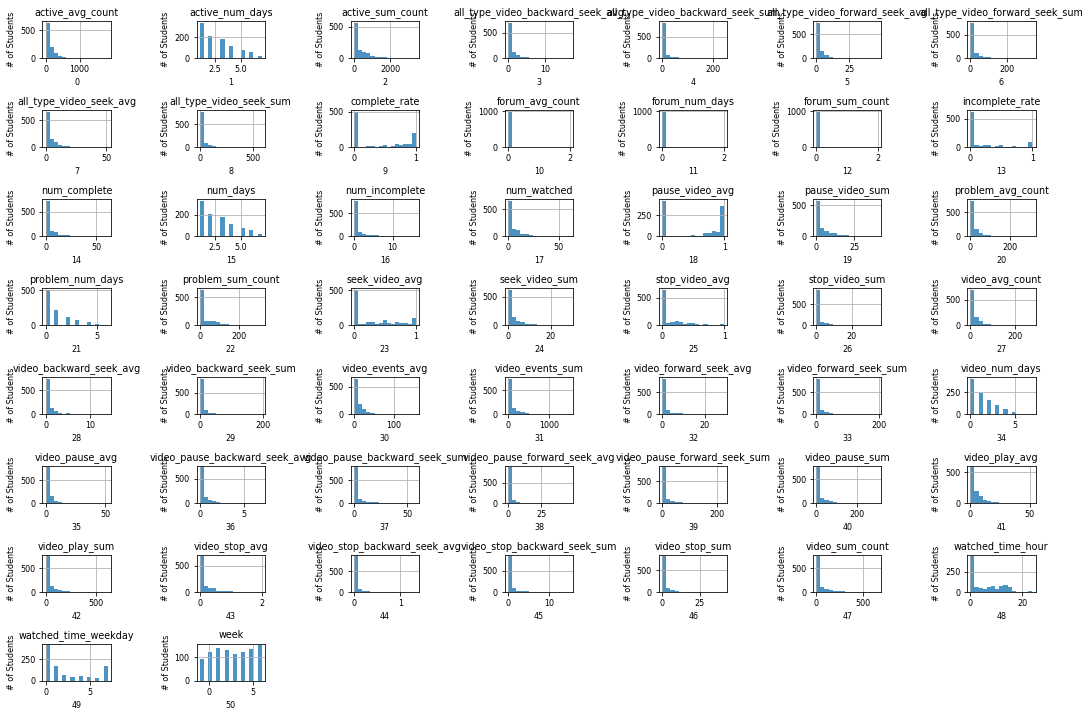

In [30]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15, 15))
ax = feature_df.hist(alpha=0.8, bins=15, figsize=(15, 10))
#for x in ax:
#     x.set_title('x')

i=0
for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel(i)
        i=i+1
plt.tight_layout()